<div style="text-align: center">
<h1>PCS Computational Science Project:</h1>
<h2>Unsupervised and supervised analysis of protein sequences</h2>
</div>
<div style="text-align: right">
Joseph TOUZET<br/>
novembre 2023
</div>

We will start with the imports:

In [1]:
%%capture
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.cluster import KMeans

plt.style.use('seaborn')
from matplotlib.pyplot import figure

figure(figsize=(8, 6), dpi=80)

## Task 1

We will then read and _one-hot encode_ the data.

In [2]:
def read_data(filename):
    with open(filename) as f:
        lines = f.readlines()
        data = []
        
        for line in lines:
            if line[0] == ">":
                properties = line[1:-1].split(" ")
                
                name       = properties[0]
                functional = properties[1].split("_")[1] == "true"

                data.append({
                    "name"       : name,
                    "functional" : functional,
                    "sequence"   : ""
                })
            else:
                data[-1]["sequence"] += line[:-1]

        return data

def hot_encode_sequence(sequence):
    alphabet = ["A", "C", "D", "E", "F", "G", "H", "I", "K", "L", "M", "N", "P", "Q", "R", "S", "T", "V", "W", "Y", "-"]
    encoded_sequence = []
    
    for letter in sequence:
        encoded_letter = [0]*(len(alphabet) - 1)
        letter_idx = alphabet.index(letter)
        if letter_idx < len(alphabet) - 1:
            encoded_letter[letter_idx] = 1
        encoded_sequence += encoded_letter
        
    return encoded_sequence

print(hot_encode_sequence("C-W"))

def hot_encode_data(data):
    for datum in data:
        datum["hot_encoded_sequence"] = hot_encode_sequence(datum["sequence"])

[0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0]


We tried to validate our _one-hote encoding_ function on the simple sequence "C-W": This correctly gives us a 60-long vector (3*20) with only a 1 on the second place (corresponding to the first "C"), a one on the second-to last place (corresponding to the "W") with no one in between (corresponding to the "-"). 

In [3]:
data_art = read_data("MSA_art.faa")
hot_encode_data(data_art)

data_nat = read_data("MSA_nat_with_annotation.faa")
hot_encode_data(data_nat)

print(data_art[0])

{'name': 'sequence_1', 'functional': True, 'sequence': '-----SLEELRKEIESIDREIVELIARRTYVAKTIAQIKRERGLPTTDESQEQRVMERAGSNAKQFD-VDANLVKAIFKLLIELNKEEQRENR---', 'hot_encoded_sequence': [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0

We here review the encoding of the first sequence in the artificial data: we correctly read its sequencce, name, that it is functional and then one-hot encoded its sequence.

# Task 2

We will no apply PCA to the _one-hot encoded_ natural dataset to reduce its dimensionality.

In [4]:
X_nat = np.array([datum["hot_encoded_sequence"] for datum in data_nat])
X_art = np.array([datum["hot_encoded_sequence"] for datum in data_art])

In [5]:
n_components = 15
pca = PCA(n_components=n_components)
eigen_values  = pca.fit_transform(X_nat)
eigen_vectors = pca.components_

In [6]:
functional_mask            = np.array([    datum["functional"] for datum in data_nat])
functional_eigen_value     = eigen_values[    functional_mask]
non_functional_mask        = np.array([not datum["functional"] for datum in data_nat])
non_functional_eigen_value = eigen_values[non_functional_mask]

print(f"{ len(functional_eigen_value) } functional sequences, { len(non_functional_eigen_value) } non-functional sequences for a total of { len(eigen_values) } sequences.")

423 functional sequences, 707 non-functional sequences for a total of 1130 sequences.


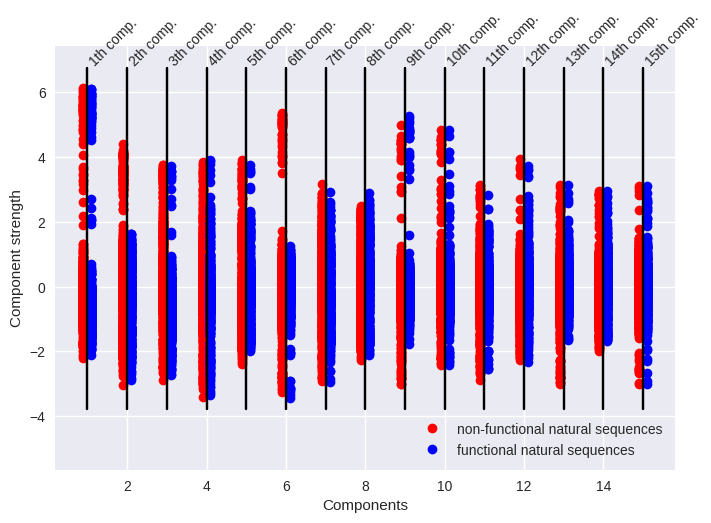

In [7]:
Min, Max = 1.1*np.min(eigen_values), 1.1*np.max(eigen_values)

for component in range(n_components):
    plt.plot(
        np.full(len(non_functional_eigen_value), component + 0.9),
        non_functional_eigen_value[:,component],
        "ro", label=("non-functional natural sequences" if component==0 else '_nolegend_'))
    
    plt.plot(
        np.full(len(functional_eigen_value),     component + 1.1),
        functional_eigen_value    [:,component],
        "bo", label=("functional natural sequences"  if component==0 else '_nolegend_'))

    plt.plot([component+1, component+1], [Min, Max], "k-")
    plt.text(component+1, Max, f"{component+1}th comp.",
            rotation=45,
            horizontalalignment="left", verticalalignment="bottom")

plt.ylim([Min*1.5, Max*1.1])
plt.xlabel("Components")
plt.ylabel("Component strength")
plt.legend(loc="lower right")

For some principal components (the 1st, 2nd, 6th for exemple) the functional and non-functional sequences occupy the same space, but some part of the space is reserved for one or the other (for exemple only non-fonctional sequence occupy the $[2, 4]$ space for the 2nd component, whereas both functional and non-functional sequences occupy the $[-3, 2]$ space for this component).

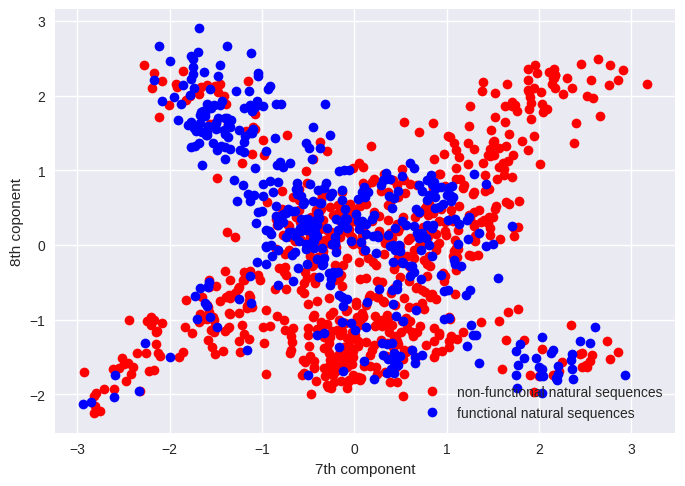

In [8]:
n1, n2 = 6, 7

plt.plot(
    non_functional_eigen_value[:,n1],
    non_functional_eigen_value[:,n2],
    "ro", label="non-functional natural sequences")
    
plt.plot(
    functional_eigen_value[:,n1],
    functional_eigen_value[:,n2],
    "bo", label="functional natural sequences")

plt.xlabel(f"{n1+1}th component")
plt.ylabel(f"{n2+1}th coponent")
plt.legend(loc="lower right")

For other component (thhe 7th and 8th for exemple) the space seems fully shared. We would need to look at the higher dimensional data to see if in the 10th dimensional space they actually share the same space. In the last figure we see that in the 2D space of the 7th and 8th PCs, the functional and non-functional sequences are somewhat separated even though in the separate 1D-space of the 7th and 8th PCs they aren't separated.

We could expect that in the 10 dimentional PC space functional and non-functional sequence, which we will prove by clustering them.

## Task 3

We will now cluster the data using the K-mean method.

In [9]:
%%capture
n_cluster = 50

est = KMeans(n_cluster)
est.fit(X_nat)
clustering = est.predict(X_nat)

In [10]:
avg_functionality, cluster_size = [], []
functionality = np.array([datum["functional"] for datum in data_nat])

for cluster in range(n_cluster):
    cluster_mask = [cluster_idx == cluster for cluster_idx in clustering]
    cluster_functionality = functionality[cluster_mask]
    
    avg_functionality.append(np.mean(cluster_functionality))
    cluster_size.append(len(cluster_functionality))

In [11]:
functional_functional, nonFunctional_functional = 0, 0
functional_nonFunctional, nonFunctional_nonFuctional = 0, 0

cutoff = len(functional_eigen_value)/len(eigen_values)

for cluster in range(n_cluster):
    if avg_functionality[cluster] > cutoff:
        functional_functional      +=      avg_functionality[cluster] *cluster_size[cluster]
        nonFunctional_functional   += (1 - avg_functionality[cluster])*cluster_size[cluster]
    else:
        functional_nonFunctional   +=      avg_functionality[cluster] *cluster_size[cluster]
        nonFunctional_nonFuctional += (1 - avg_functionality[cluster])*cluster_size[cluster]

print(f"{round(functional_functional)} functional sequence",
f"and {round(nonFunctional_functional)} non-functional sequences in cluster with more than {round(cutoff*100)}% of functional sequences,",
f"corresponding to {round(functional_functional/(functional_functional + nonFunctional_functional)*100)}% functional sequences in this group,",
f"and {round(functional_functional/len(functional_eigen_value)*100)}% of all functional sequences")

print(f"{round(functional_nonFunctional)} functional sequence",
f"and {round(nonFunctional_nonFuctional)} non-functional sequences in cluster with less than {round(cutoff*100)} of functional sequences,",
f"corresponding to {round(nonFunctional_nonFuctional/(functional_nonFunctional + nonFunctional_nonFuctional)*100)}% non-functional sequences in this group,",
f"and {round(nonFunctional_nonFuctional/len(non_functional_eigen_value)*100)}% of all non-functional sequences")

346 functional sequence and 183 non-functional sequences in cluster with more than 37% of functional sequences, corresponding to 65% functional sequences in this group, and 82% of all functional sequences
77 functional sequence and 524 non-functional sequences in cluster with less than 37 of functional sequences, corresponding to 87% non-functional sequences in this group, and 74% of all non-functional sequences


After trying multiple number of clusters, and playing with the "cutoff" (we choose a cutoff equal to the global proportion of functional sequences) at which we choose if a cluster is a "primarly functional" cluster or a "primarly non-functional" cluster, we separated clusters in those two groups:
 - a majority (64%) of sequences in "primarly functional clusters" are functional.
 - a large majority (85%) of sequences in "primarly non-functional clusters" are non-functional.
 - a large majority (78%) of functional sequences end up in "primarly functional clusters".
 - a large majority (74%) of non-functional sequences end up in "primarly non-functional clusters".

We can conclude that functional and non-functional sequences are somewhat separated in the clusters, and thus are separated in PCs space.

## Task 4

We will now train a model that can classify between functional and non-functional proteins:

In [12]:
Y_nat = np.array([datum["functional"] for datum in data_nat])
X_train, X_test, Y_train, Y_test = train_test_split(X_nat, Y_nat, test_size=0.3, random_state=1)

Y_art = np.array([datum["functional"] for datum in data_art])

### 4.a - Decision Tree

We first use a _decision tree_ model similar to one that we used in a previous TD:

In [13]:
%%capture
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import AdaBoostClassifier

# example stollen from the classifier TD
weak_classifier = DecisionTreeClassifier(max_depth=1, random_state=5)                            # here we define the weak classifier                
strong_classifier = AdaBoostClassifier(n_estimators=50, base_estimator=weak_classifier)     # here we build the strong classifier

model_decisionTree = strong_classifier.fit(X_train, Y_train)

In [14]:
def print_accuracy_matrix(test_function, X, Y):
    TP = test_function(X[Y], Y[Y])
    FN = 1 - TP #predicted negative while actually positive => false negative
    TN = test_function(X[Y==0], Y[Y==0])
    FP = 1 - TN #predicted positive while actually negative => false positive

    print(f"TP: {round(TP*100)}%, FP: {round(FP*100)}%")
    print(f"FN: {round(FN*100)}%, TN: {round(TN*100)}%")

print("Natural data, test:")
print_accuracy_matrix(model_decisionTree.score, X_test, Y_test)

print("\nNatural data, train:")
print_accuracy_matrix(model_decisionTree.score, X_train, Y_train)

print("\nArtificial data:")
print_accuracy_matrix(model_decisionTree.score, X_art, Y_art)

Natural data, test:
TP: 64%, FP: 17%
FN: 36%, TN: 83%

Natural data, train:
TP: 81%, FP: 9%
FN: 19%, TN: 91%

Artificial data:
TP: 74%, FP: 18%
FN: 26%, TN: 82%


We can see that the true positive (TP) and true negative (TP) rates are higher for the data we trained on than the test data.

Interestingly we can observe that the model's TP is better on the artificial data than the natural data. We could assue that the artificial data has been generated by a generator trained to maximize such a model, thus artificial data could be easier to distinguish for our model. 

### 4.b - Logistic regression

We will now move on to a simple logistic regression model:

In [15]:
%%capture
from sklearn.linear_model import LogisticRegression

model_logic = LogisticRegression()
model_logic.fit(X_train, Y_train)

In [16]:
print("Natural data, test:")
print_accuracy_matrix(model_logic.score, X_test, Y_test)

print("\nNatural data, train:")
print_accuracy_matrix(model_logic.score, X_train, Y_train)

print("\nArtificial data:")
print_accuracy_matrix(model_logic.score, X_art, Y_art)

Natural data, test:
TP: 65%, FP: 13%
FN: 35%, TN: 87%

Natural data, train:
TP: 100%, FP: 0%
FN: 0%, TN: 100%

Artificial data:
TP: 73%, FP: 18%
FN: 27%, TN: 82%


We obtain verry similar results to the decision tree model, and thus make largly the same observations.

### 4.c - Neural network

We will lastly use a simple neural network based classifier provided by sklearn.

For that we will first need to one-hot encode the class (functional or non-functional) thus making it a vector of size 2.

In [17]:
Y_nat_2d = np.array([[1, 0] if datum["functional"] else [0, 1] for datum in data_nat])
X_train_2d, X_test_2d, Y_train_2d, Y_test_2d = train_test_split(X_nat, Y_nat_2d, test_size=0.3, random_state=1)

Y_art_2d = np.array([[1, 0] if datum["functional"] else [0, 1] for datum in data_art])

In [18]:
%%capture
from sklearn.neural_network import MLPClassifier

model_nn = MLPClassifier(solver='lbfgs', hidden_layer_sizes=(50, 10), random_state=1, alpha=1e-5)
model_nn.fit(X_train_2d, Y_train_2d)

In [19]:
# we need a new function because the data is formated differently
def print_accuracy_matrix_NN(test_function, X, Y):
    TP = test_function(X[Y[:, 1] == 1], Y[Y[:, 1] == 1])
    FN = 1 - TP #predicted negative while actually positive => false negative
    TN = test_function(X[Y[:, 0] == 1], Y[Y[:, 0] == 1])
    FP = 1 - TN #predicted positive while actually negative => false positive

    print(f"TP: {round(TP*100)}%, FP: {round(FP*100)}%")
    print(f"FN: {round(FN*100)}%, TN: {round(TN*100)}%")

# we need to define the accuracy function for the evaluation by hand
def nn_cost_function(X, Y):
    prediction = model_nn.predict(X)
    return np.mean(prediction[:, 0] == Y[:, 0])

print("Natural data, test:")
print_accuracy_matrix_NN(nn_cost_function, X_test_2d, Y_test_2d)

print("\nNatural data, train:")
print_accuracy_matrix_NN(nn_cost_function, X_train_2d, Y_train_2d)

print("\nArtificial data:")
print_accuracy_matrix_NN(nn_cost_function, X_art, Y_art_2d)

Natural data, test:
TP: 87%, FP: 42%
FN: 13%, TN: 58%

Natural data, train:
TP: 100%, FP: 0%
FN: 0%, TN: 100%

Artificial data:
TP: 85%, FP: 29%
FN: 15%, TN: 71%


The neural network-based model is significantly slower to train without having a huge advantage in discriminating between functional and non-functional proteins.

## Task 5

Blabla...